# Exploratory Data Analysis for the QM9 Dataset

To get a feel for the dataset, it is helpful to start by visualising both the molecular graphs as well as the distribution of properties (like HOMO-LUMO). We can also visualise correlations between different properties to identify which targets might be most helpful, but since this is a toy project, we will skip this for now.

TODO : discuss what the QM9 dataset is and the basic theory of molecular graphs

In [2]:
import torch_geometric as pyg
import torch
from torch_geometric.datasets import QM9
from torch_geometric.data import DataLoader
import mygenai
from rdkit import Chem
from IPython.display import SVG

# using the QM9 dataset, as it includes quantum properties and is of modest size
# TODO !!! 
dataset = QM9(root="../data/QM9")

## Molecule Visualisation

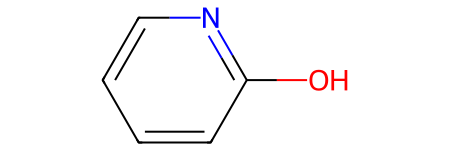

In [3]:
# illustrate use of visualisation tools
m = Chem.MolFromSmiles('c1cccnc1O')
SVG(mygenai.utils.visualisation.moltosvg(m))

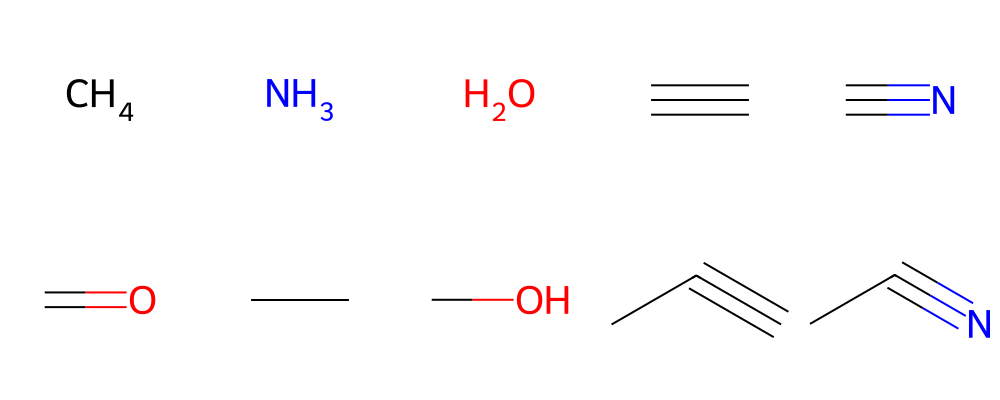

In [4]:
# visualise the top 10 molecules in the dataset
num_viz = 10
mols = [mygenai.utils.visualisation.to_rdkit(dataset[i]) for i in range(num_viz)]
Chem.Draw.MolsToGridImage(mols, molsPerRow=5)

In [5]:
# 3d visualisation of first molecule
test_mol = dataset[2]
mygenai.utils.visualisation.visualise_molecule(test_mol)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [14]:
# 3d visualisation of a more complex molecule
test_mol = dataset[2]
mygenai.utils.visualisation.visualise_molecule(test_mol)
test_mol.pos

tensor([[-3.4400e-02,  9.7750e-01,  7.6000e-03],
        [ 6.4800e-02,  2.0600e-02,  1.5000e-03],
        [ 8.7180e-01,  1.3008e+00,  7.0000e-04]])

In [15]:
a = [-3.4400e-02,  9.7750e-01,  7.6000e-03]
b = [ 6.4800e-02,  2.0600e-02,  1.5000e-03]
diff = sum([(a[i] - b[i])**2 for i in range(3)])**0.5
print(diff)

0.9620475352081103


## Data Distribution Visualisation

In [69]:
def compute_max_distance(dataset):
    max_distance = 0.0
    max_distance_old = 0.0
    min_distance = torch.inf
    min_distance_old = torch.inf
    for i, data in enumerate(dataset):
        pos = data.pos  # (n, 3) - absolute coordinates
        src, dst = data.edge_index  # (2, num_edges) - edge indices
        relative_positions = pos[dst] - pos[src]  # (num_edges, 3)
        distances = torch.norm(relative_positions, dim=1)  # (num_edges,)
        max_distance = max(max_distance, distances.max().item())
        if max_distance > max_distance_old:
            max_distance_old = max_distance
            argmax = i
            # mygenai.utils.visualisation.visualise_molecule(data)
            # SVG(mygenai.utils.visualisation.moltosvg(m))
        min_distance = min(min_distance, distances.min().item())
        if min_distance < min_distance_old:
            min_distance_old = min_distance
            argmin = i
    return max_distance, argmax, min_distance, argmin

# Example usage
max_distance, argmax, min_distance, argmin = compute_max_distance(dataset)
print(f"Maximum distance in dataset: {max_distance:.4f}")
print(f"Minimum distance in dataset: {min_distance:.4f}")
# max distance is a little less than 2

Maximum distance in dataset: 1.8100
Minimum distance in dataset: 0.9587


In [64]:
maxmol = dataset[argmax]
print(maxmol.z)
minmol = dataset[argmin]
print(minmol.z)
mygenai.utils.visualisation.visualise_molecule(minmol)

tensor([6, 6, 6, 8, 6, 6, 6, 6, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([6, 6, 6, 6, 8, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [6]:
# basic statistics
print(f"Total graphs: {len(dataset)}")

num_nodes = [data.num_nodes for data in dataset]
num_edges = [data.num_edges for data in dataset]

print(f"Avg nodes per graph: {sum(num_nodes) / len(num_nodes):.2f}")
print(f"Avg edges per graph: {sum(num_edges) / len(num_edges):.2f}")

Total graphs: 130831
Avg nodes per graph: 18.03
Avg edges per graph: 37.33


Apparently these HOMO-LUMO gaps were "determined using ab-initio density functional theory (PBE0/tier2 basis set)" [^1] -- this is cited directly in the pytorch-geometric dataset [^2]

However, it is also reported [^3] [^4] to be DFT with B3LYP/6-31G(2df,p) level of quantum chemistry. Based on the below, it seems like this is more likely. We are still off by about 1 mHa for the first couple of molecules for some reason, but this is within chemical accuracy (so a very small difference) of the dataset, which might be attributed e.g. to the software used. Therefore, for my study I will use B3LYP/6-31G(2df,p).  

[^1]: https://arxiv.org/pdf/1703.00564
[^2]: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.QM9.html
[^3]: http://quantum-machine.org/datasets/
[^4]: https://www.nature.com/articles/sdata201422

In [14]:
# verify the HOMO-LUMO gap for the first ten molecules in the dataset
from pyscf import gto, dft
from pyscf import grad
import numpy as np
for i in range(10):
    mol_data = dataset[i]
    atomic_numbers = mol_data.z.numpy()
    positions = mol_data.pos.numpy()
    qm9_gap = mol_data.y[:, 4].item()
    # print(qm9_gap)
    print(f"Molecule {i}: {mygenai.utils.get_molecular_formula(atomic_numbers)}")


    HARTREE2EV = 27.211386246

    # Create PySCF molecule object
    mol = gto.Mole()
    mol.atom = [(int(atomic_numbers[i]), positions[i]) for i in range(len(atomic_numbers))]
    # mol.basis = "def2-SVP"  # Approximation to 'tier2' basis set
    mol.basis = "6-31G(2df,p)"  # Approximation to 'tier2' basis set

    # B3LYP/6-31G(2df,p) ?? See quantum machine website
    mol.build()

    # Run DFT
    mf = dft.RKS(mol)
    # mf.xc = "PBE0"
    mf.xc = "B3LYP"
    mf.kernel()

    # get HOMO-LUMO
    mo_energies = mf.mo_energy  # in Hartree
    homo_idx = mol.nelectron // 2 - 1
    lumo_idx = homo_idx + 1

    homo_lumo_gap = (mo_energies[lumo_idx] - mo_energies[homo_idx]) * HARTREE2EV

    print(f"HOMO-LUMO gap (DFT, {mf.xc}/{mol.basis}): {homo_lumo_gap:.3f} eV")
    print(f"QM9 target HOMO-LUMO gap: {qm9_gap:.3f} eV")

    error = abs(homo_lumo_gap - qm9_gap)
    print(f"Difference: {error:.3f} eV")

    # verify molecule is stable
    mfgrad = grad.RKS(mf)
    gradients = mfgrad.kernel()
    print("Gradient magnitudes:", [np.linalg.norm(gradients[i,:]) for i in range(gradients.shape[0])])

Molecule 0: CH4
converged SCF energy = -40.5231129315059
HOMO-LUMO gap (DFT, B3LYP/6-31G(2df,p)): 13.766 eV
QM9 target HOMO-LUMO gap: 13.736 eV
Difference: 0.030 eV
--------------- RKS gradients ---------------
         x                y                z
0 C    -0.0000234273    -0.0000032339    -0.0000253993
1 H     0.0000072981    -0.0002727173     0.0000001698
2 H     0.0002703390     0.0000976984     0.0000007535
3 H    -0.0001253657     0.0000858623    -0.0002103452
4 H    -0.0001300321     0.0000910191     0.0002346644
----------------------------------------------
Gradient magnitudes: [3.470475122477557e-05, 0.00027281500768213144, 0.00028745207575793535, 0.0002594879885805813, 0.00028330231790632483]
Molecule 1: H3N
converged SCF energy = -56.5592137935974
HOMO-LUMO gap (DFT, B3LYP/6-31G(2df,p)): 9.231 eV
QM9 target HOMO-LUMO gap: 9.249 eV
Difference: 0.018 eV
--------------- RKS gradients ---------------
         x                y                z
0 N    -0.0003767143     0.0

HOMO-LUMO Gap Statistics:
Minimum: 0.6694 eV
Maximum: 16.9282 eV
Mean: 6.8585 eV
Median: 6.8083 eV


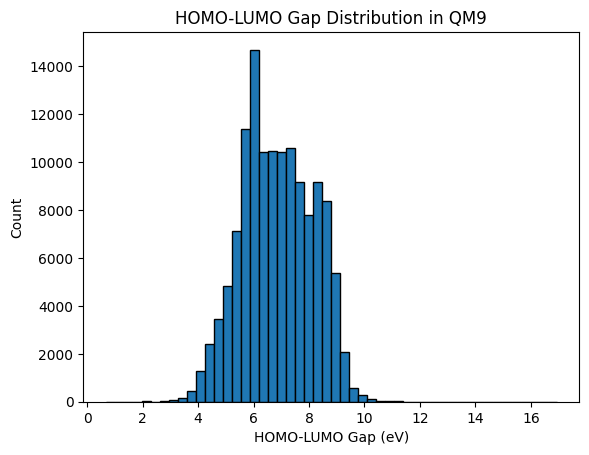

In [12]:
# HOMO-LUMO distribution
import matplotlib.pyplot as plt
import torch
homo_lumo_gaps = torch.cat([data.y[:, 4] for data in dataset])  # Column 4 is HOMO-LUMO gap

# Calculate statistics for HOMO-LUMO gaps
min_gap = torch.min(homo_lumo_gaps).item()
max_gap = torch.max(homo_lumo_gaps).item()
mean_gap = torch.mean(homo_lumo_gaps).item()
median_gap = torch.median(homo_lumo_gaps).item()

print(f"HOMO-LUMO Gap Statistics:")
print(f"Minimum: {min_gap:.4f} eV")
print(f"Maximum: {max_gap:.4f} eV")
print(f"Mean: {mean_gap:.4f} eV")
print(f"Median: {median_gap:.4f} eV")

plt.hist(homo_lumo_gaps.numpy(), bins=50, edgecolor="black")
plt.xlabel("HOMO-LUMO Gap (eV)")
plt.ylabel("Count")
plt.title("HOMO-LUMO Gap Distribution in QM9")
plt.show()

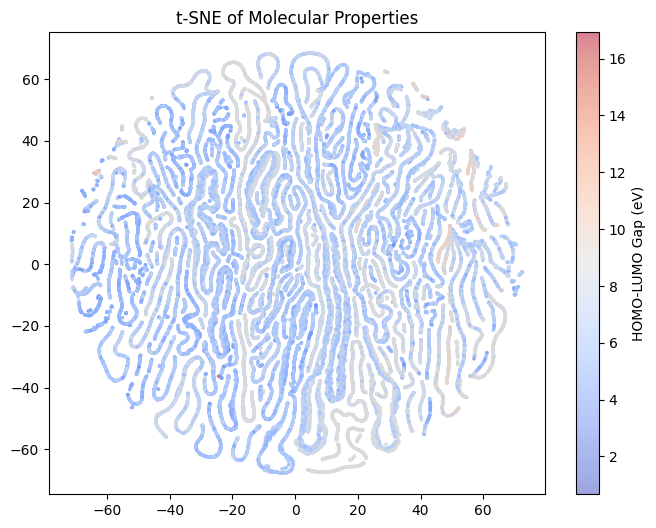

In [11]:
# use PCA to reduce dimensionality to 5D
# then tSNE to reduce to 2D
# colour code according to HOMO-LUMO gap to
# get an idea of the distribution

import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# graph/molecule/target properties
Y = torch.cat([data.y for data in dataset], dim=0).numpy()

homo_lumo_gap = Y[:, 4]

pca = PCA(n_components=4)
Y_pca = pca.fit_transform(Y)

# Apply t-SNE on reduced 5D space
tsne = TSNE(n_components=2, random_state=42, n_jobs=16, method='barnes_hut', max_iter=500)
Y_embedded = tsne.fit_transform(Y_pca)

plt.figure(figsize=(8, 6))
plt.scatter(Y_embedded[:, 0], Y_embedded[:, 1], c=homo_lumo_gap, cmap="coolwarm", alpha=0.5, s=2)
plt.colorbar(label="HOMO-LUMO Gap (eV)")
plt.title("t-SNE of Molecular Properties")
plt.show()